# Analysis of results from experimental campaign

This notebook explores and visualize the results on `MicroGridEnv` adopting different strategies. The results are retrieved from some `json`files employed to store the outcome from the testing of each tested algorithm. <br>
The plots shown here have been also used within the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm 
from datetime import datetime
import os
import orjson as json
from pathlib import Path
from collections import OrderedDict

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

plots_dir = 'examples/single_agent/plots'
os.makedirs(plots_dir, exist_ok=True)

In [3]:
alg_color = OrderedDict({
    'random': plot_colors[0],
    'only_market': plot_colors[1],
    'battery_first': plot_colors[2],
    '20-80': plot_colors[3],
    '50-50': plot_colors[4],
    'ppo': plot_colors[5],
    'a2c': plot_colors[6],
    'sac': plot_colors[7]
})

alg_markers = OrderedDict({
    'random': '.',
    'only_market': 'o',
    'battery_first': 'v',
    '20-80': 's',
    '50-50': 'P',
    'ppo': '*',
    'a2c': '+',
    'sac': '<'
})

In [4]:
exp_name = "rev3_final"
folder = "./logs/{}/results/".format(exp_name)

do_not_save = True

In [5]:
algs = [f for f in alg_color.keys() if f in os.listdir(folder)]

In [6]:
#algs.remove('random')
#algs.remove('battery_first')
#algs.remove('50-50')
#algs.remove('20-80')

In [7]:
algs

['random',
 'only_market',
 'battery_first',
 '20-80',
 '50-50',
 'ppo',
 'a2c',
 'sac']

In [8]:
def load_results(alg:str):

    alg_res = []

    results_folder = folder + alg +'/'
    tests_files = [f for f in os.listdir(results_folder)]

    for file in tqdm(tests_files):
        f = open (results_folder + file, "r")
        data = json.loads(f.read())
        alg_res.append(data)

    return alg_res

In [9]:
res_dict = {}

for alg in algs:
    res_dict[alg] = load_results(alg)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.09s/it]


In [10]:
timestamps = pd.read_csv("ernestogym/ernesto/data/demand/dataset.csv", usecols=['timestamp'])['timestamp'].values.tolist()

In [11]:
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps]

In [12]:
algs

['random',
 'only_market',
 'battery_first',
 '20-80',
 '50-50',
 'ppo',
 'a2c',
 'sac']

In [13]:
alg_names = {
    'a2c': 'A2C',
    'battery_first': 'Battery-first',
    '20-80': '20-80',
    'random': 'Random',
    'ppo': 'PPO',
    '50-50': '50-50',
    'only_market': 'Only-market',
    'sac': 'SAC'
}

In [14]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

## PLOTS

In [15]:
# Average return across all the test experiments throw boxplots
def average_return(r_type:str = 'norm_reward'):
    data = {}
    colors = []
    
    for alg in algs:
        if r_type == 'weighted_reward':
            data[alg_names[alg]] = [res_dict[alg][i]['total_reward'] for i in range(len(res_dict[alg]))]
        else:
            data[alg_names[alg]] = [sum(res_dict[alg][i][r_type]['r_trad']) - 
                                    sum(res_dict[alg][i][r_type]['r_op']) - 
                                    sum(res_dict[alg][i][r_type]['r_clip'])
                                    for i in range(len(res_dict[alg]))]
        colors.append(alg_color[alg])
            
    fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
    box_plot = sns.boxplot(data, gap=.1, palette=colors)
    
    medians = [np.mean(values) for key, values in data.items()]
    vertical_offset = 1000 # offset from median for display

    for xtick, alg in zip(box_plot.get_xticks(), algs):
        box_plot.text(xtick, vertical_offset, round(medians[xtick]), 
                      horizontalalignment='center',size='x-small', color=alg_color[alg], weight='semibold')
    
    print({key: np.mean(values) for key, values in data.items()})    
    
    savefig(fig, filename='{}-average_return.pdf'.format(exp_name))
    savefig(fig, filename='{}-average_return.png'.format(exp_name))
    
    return data

{'Random': -21511.959872820462, 'Only-market': -6225.3626515519045, 'Battery-first': -40791.04563121185, '20-80': -11837.283102680001, '50-50': -21461.819323700718, 'PPO': -6199.234213216434, 'A2C': -6225.32096473638, 'SAC': -11438.898447391606}


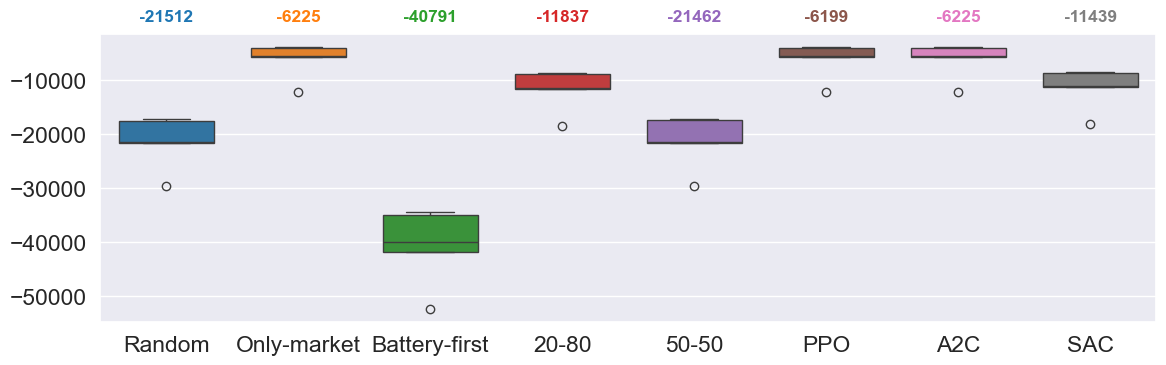

In [16]:
df = pd.DataFrame.from_dict(average_return(r_type='norm_reward'))

In [17]:
df.describe()

,Random,Only-market,Battery-first,20-80,50-50,PPO,A2C,SAC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-21511.959873,-6225.362652,-40791.045631,-11837.283103,-21461.819324,-6199.234213,-6225.320965,-11438.898447
std,5023.561603,3457.482605,7237.203499,3976.326560,5064.639888,3435.550630,3457.506305,3914.886979
min,-29674.753901,-12226.373511,-52396.060182,-18528.596865,-29664.972773,-12162.588386,-12226.402592,-18038.921018
25%,-21695.425840,-5678.614924,-41964.316456,-11581.702434,-21663.761397,-5654.718888,-5678.430613,-11169.399389
50%,-21438.612247,-5430.083102,-40074.058659,-11440.412096,-21449.853414,-5407.823953,-5430.034212,-11021.682680
75%,-17539.667026,-3996.234853,-35079.771530,-8902.279704,-17419.115086,-3988.147226,-3996.250349,-8568.149557
max,-17211.340350,-3795.506868,-34441.021331,-8733.424414,-17111.393949,-3782.892614,-3795.487058,-8396.339593


In [18]:
def cum_average_reward_terms_comparison(sampling_rate=10, reward_type='weighted_reward'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Time', ylabel='Avg. Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Time', ylabel='Avg. Operational Cost', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Time', ylabel='Avg. Action Clipping', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='{}-avg_cum_terms_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_{}.png'.format(exp_name, reward_type))

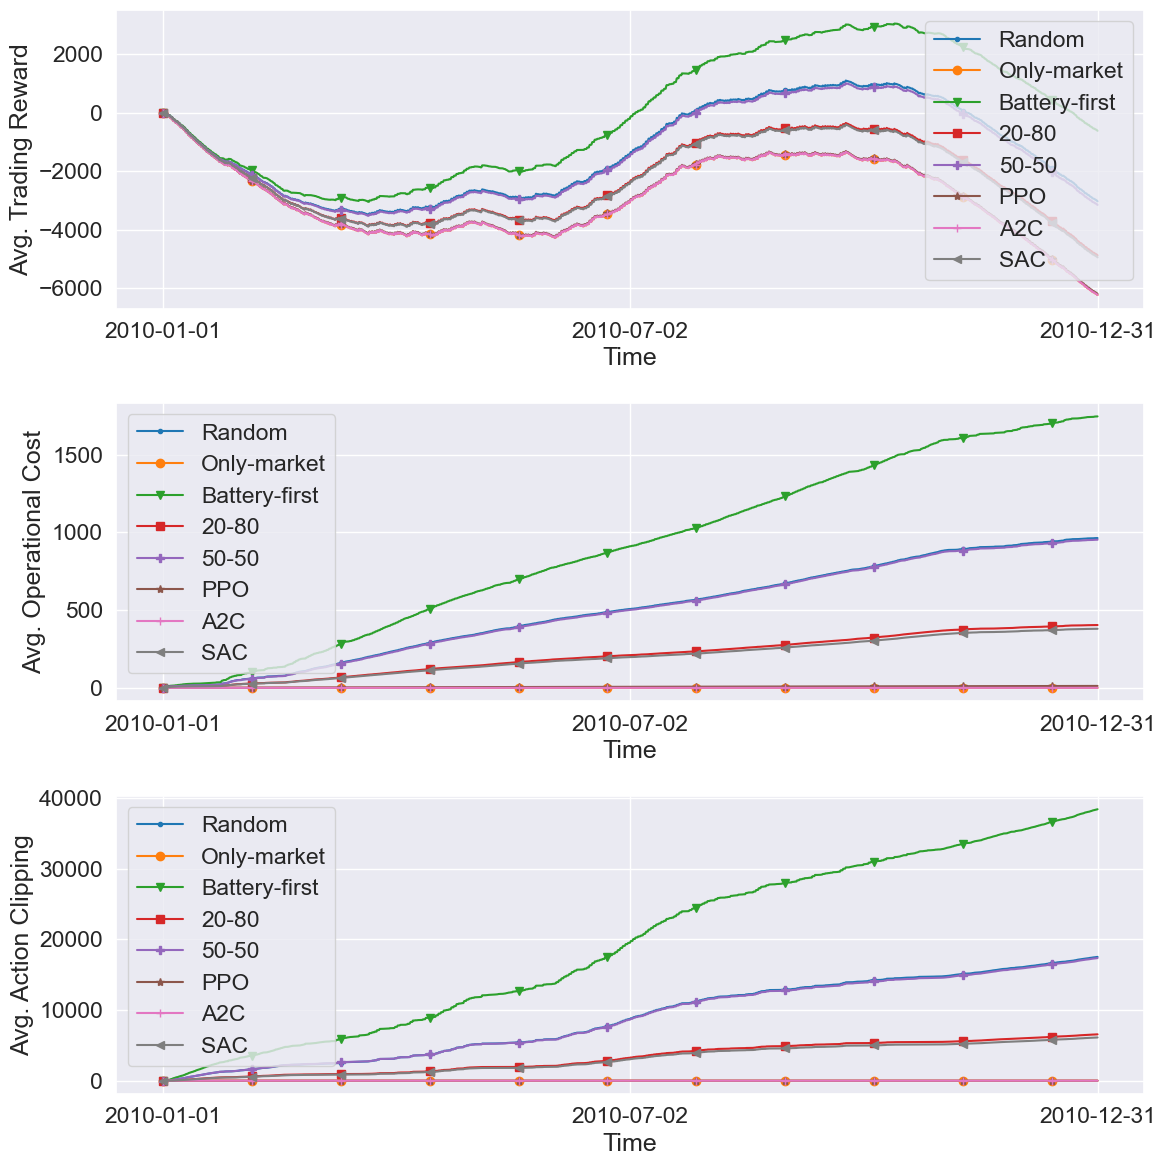

In [19]:
cum_average_reward_terms_comparison(reward_type='norm_reward')

In [20]:
def average_total_reward_with_baseline(sampling_rate=10, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    baseline_reward = np.cumsum(np.sum([trad_means, op_means * -1, clip_means * -1], axis=0))
    
    for i, alg in enumerate(algs):
        trad_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)
        total_reward = np.cumsum(np.sum([trad_means, op_means * -1, clip_means * -1], axis=0))
        
        ax.plot(timestamps[::sampling_rate], (total_reward - baseline_reward)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax.set(xlabel='Time', ylabel="Delta cum. reward", xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax.legend()
    
    savefig(fig, filename='{}-avg_cum_reward_with_baseline_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_reward_with_baseline_{}.png'.format(exp_name, reward_type))

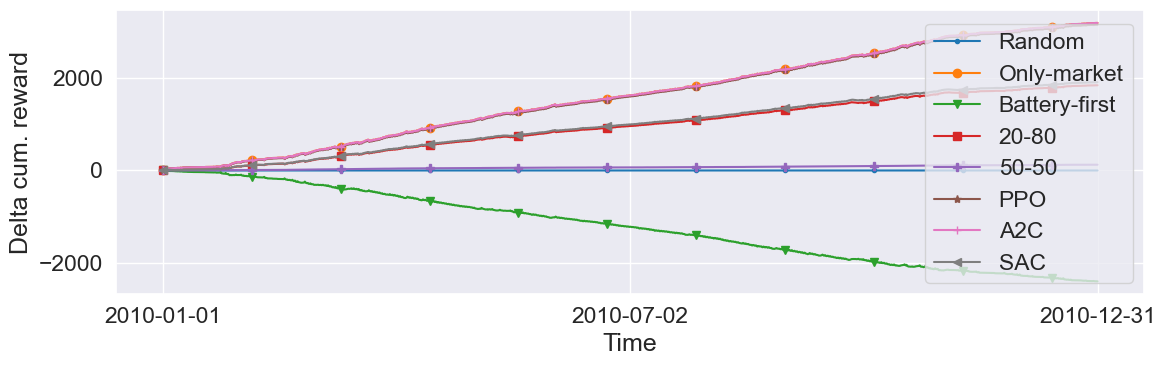

In [21]:
average_total_reward_with_baseline(reward_type='norm_reward', baseline='random')

In [22]:
def cum_average_reward_terms_with_baseline(sampling_rate=10, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_op'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_clip'] for i in range(len(res_dict[baseline]))], axis=0)     
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means - trad_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Time', ylabel='Delta cum. R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means - op_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Time', ylabel='Delta cum. R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means - clip_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Time', ylabel='Delta cum. R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='{}-avg_cum_terms_with_baseline_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_with_baseline_{}.png'.format(exp_name, reward_type))

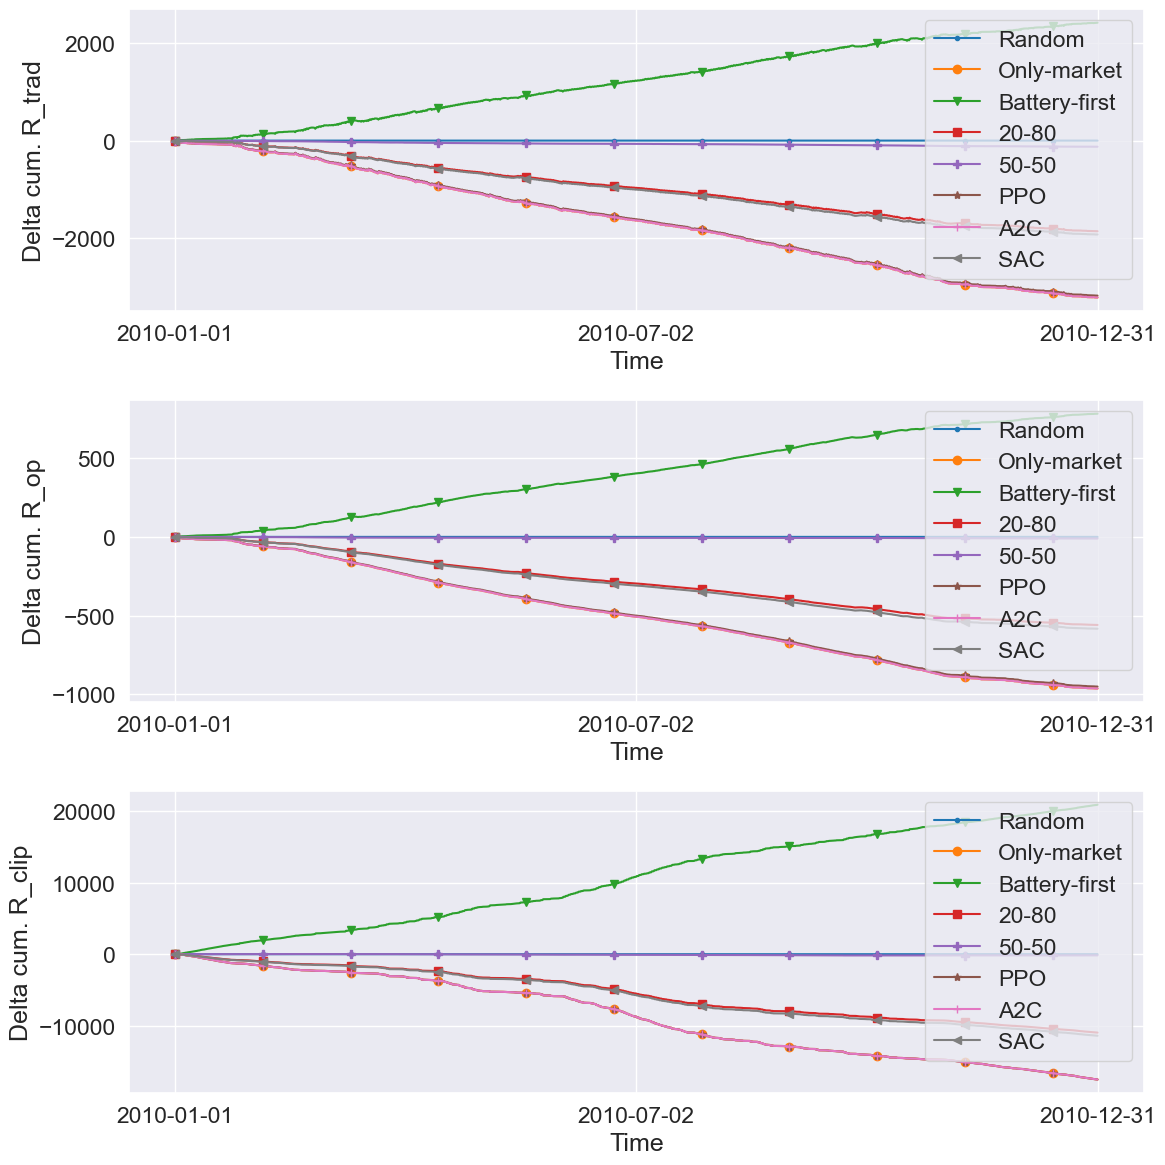

In [23]:
cum_average_reward_terms_with_baseline(reward_type='norm_reward', baseline='random')

In [24]:
def single_policy_reward_terms(alg, reward_type='weighted_reward', test='', sampling_rate=10):    
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    if not test:
        trad_list = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_list = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_list = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)     
    else:
        idx = [i for i in range(len(res_dict[alg])) if test == res_dict[alg][i]['test']][0]
        trad_list = res_dict[alg][idx][reward_type]['r_trad']   
        op_list = res_dict[alg][idx][reward_type]['r_op']     
        clip_list = res_dict[alg][idx][reward_type]['r_clip']     
    
    ax1.plot(timestamps[::sampling_rate], trad_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax1.set(xlabel='Time', ylabel='R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         

    ax2.plot(timestamps[::sampling_rate], op_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax2.set(xlabel='Time', ylabel='R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax3.plot(timestamps[::sampling_rate], clip_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax3.set(xlabel='Time', ylabel='R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
    
    savefig(fig, filename='{}-avg_cum_terms_{}_{}.pdf'.format(exp_name, alg, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_{}_{}.png'.format(exp_name, alg, reward_type))

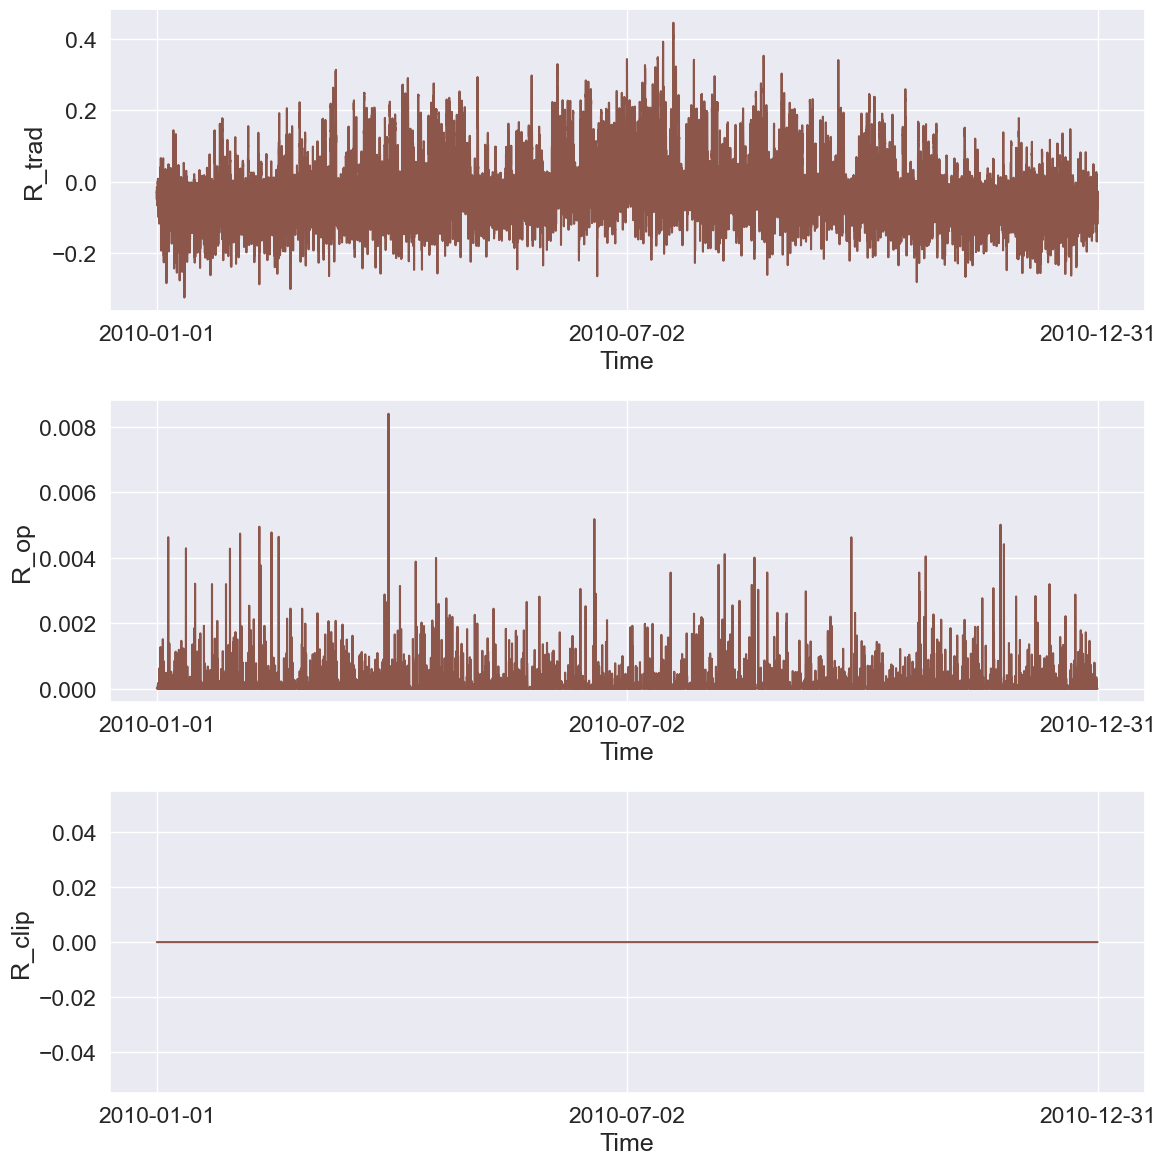

In [25]:
single_policy_reward_terms(alg='ppo', reward_type='norm_reward', test='')